## Chronos_Fx-Price Only Monthly


In [1]:
pip install chronos-forecasting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 5.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
from chronos import BaseChronosPipeline

pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/478M [00:00<?, ?B/s]

Data (B): 2000-01-31 → 2025-11-10 | n=6726
Data (D): 2000-01-31 → 2025-11-10 | n=9416

Dropped months and reasons:
  2000-01: no_cut_in_prev_month
  2000-02: hist<40
  2000-03: hist<40

=== Model performance (monthly mean, EUR/NOK) ===
Observations: 308
RMSE (level): 0.144389
MAE  (level): 0.097390
Directional accuracy: 215/307 (70.0%)

=== Diebold–Mariano vs Random Walk (driftless, cut-level) ===
Loss: MSE | horizon h=1
DM-statistic: 1.3264
p-value     : 0.1847


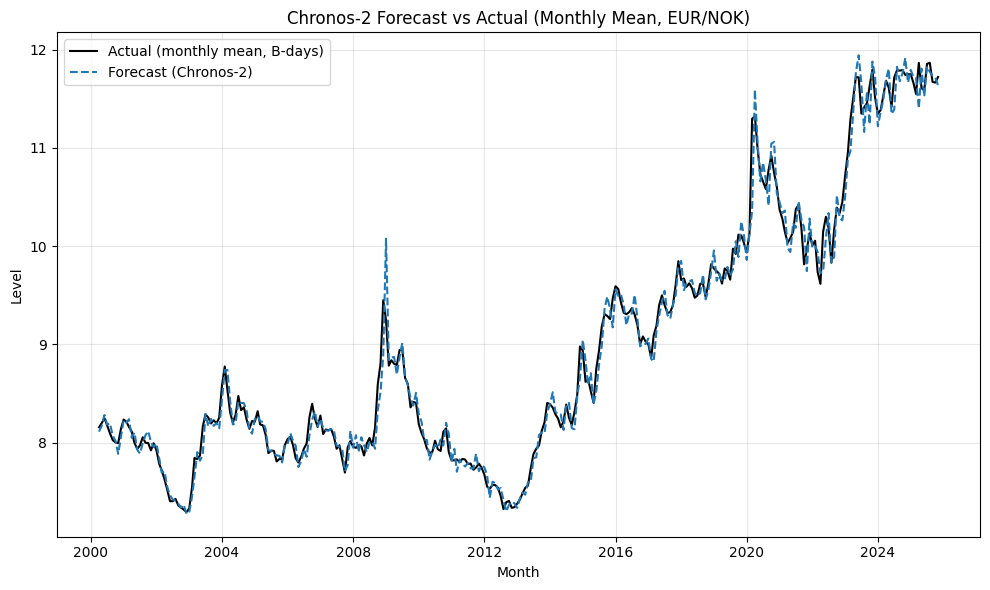

Saved: Chronos2M.png
Saved: Chronos2M.pdf


In [3]:
# -*- coding: utf-8 -*-
"""
Chronos-2 – EUR/NOK walk-forward (monthly, levels), point forecast only (price-only)

- Data: GitHub all-variables daily panel; uses only EUR_NOK
- Cut: last business day of previous month (from business-day series S_b)
- Forecast: next calendar month at daily frequency -> aggregate to monthly mean over business days
- Metrics: Observations, RMSE, MAE, Directional accuracy
- DM-test vs driftless Random Walk (cut-level) using MSE, h=1
- Plot: Actual vs Forecast (no intervals)
"""

from __future__ import annotations

import io
import time
import math
from dataclasses import dataclass
from typing import Optional, Tuple, Dict, Callable

import numpy as np
import pandas as pd
import requests
import certifi
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import torch
from chronos import BaseChronosPipeline  # pip install chronos-forecasting


# -----------------------------
# Configuration
# -----------------------------
@dataclass
class Config:
    url: str = (
        "https://raw.githubusercontent.com/bredeespelid/"
        "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_daily.csv"
    )
    target_series: str = "EUR_NOK"
    m_freq: str = "M"
    min_hist_days: int = 40
    max_context: int = 2048
    max_horizon: int = 64
    retries: int = 3
    timeout: int = 60
    verbose: bool = True
    fig_png: str = "Chronos2M.png"
    fig_pdf: str = "Chronos2M.pdf"
    device_map: str = "cuda"
    dtype: torch.dtype = torch.float16
    model_id: str = "amazon/chronos-2"


CFG = Config()


# -----------------------------
# Download helper
# -----------------------------
def download_csv_text(url: str, retries: int, timeout: int) -> str:
    last_err = None
    for k in range(1, retries + 1):
        try:
            r = requests.get(url, timeout=timeout, verify=certifi.where())
            r.raise_for_status()
            return r.text
        except Exception as e:
            last_err = e
            if k < retries:
                wait = 1.5 * k
                print(f"[warning] Download failed (try {k}/{retries}): {e}. Retrying in {wait:.1f}s ...")
                time.sleep(wait)
    raise RuntimeError(f"Download failed: {last_err}")


# -----------------------------
# Data loading
# -----------------------------
def load_series(url: str, series: str) -> Tuple[pd.Series, pd.Series]:
    """
    Returns:
      S_b: business-day (B) with ffill (used for cuts and monthly truth)
      S_d: daily (D) with ffill (model input context)
    """
    text = download_csv_text(url, CFG.retries, CFG.timeout)
    raw = pd.read_csv(io.StringIO(text))

    required_cols = {"Date", series}
    missing = required_cols - set(raw.columns)
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}. Got: {list(raw.columns)}")

    df = (
        raw[["Date", series]]
        .rename(columns={"Date": "DATE"})
        .assign(DATE=lambda x: pd.to_datetime(x["DATE"], errors="coerce"))
        .dropna(subset=["DATE", series])
        .sort_values("DATE")
        .set_index("DATE")
    )

    df[series] = pd.to_numeric(df[series], errors="coerce")
    df = df.dropna(subset=[series])

    # Business-day series
    S_b = df[series].asfreq("B").ffill().astype(float)
    S_b.name = series

    # Daily series
    full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
    S_d = df[series].reindex(full_idx).ffill().astype(float)
    S_d.index.name = "DATE"
    S_d.name = series

    return S_b, S_d


def last_trading_day(S_b: pd.Series, start: pd.Timestamp, end: pd.Timestamp) -> Optional[pd.Timestamp]:
    """Return the last available business day in [start, end]."""
    sl = S_b.loc[start:end]
    return sl.index[-1] if not sl.empty else None


# -----------------------------
# Chronos-2 model wrapper
# -----------------------------
def build_chronos2_forecast_fn(max_context: int) -> Callable[[np.ndarray, int], np.ndarray]:
    """
    Returns forecast_fn(x_1d, H) -> np.ndarray length H (daily point forecast, median/p50).
    """
    if CFG.device_map == "cuda" and not torch.cuda.is_available():
        raise SystemExit("CUDA not available. Use a CUDA build of PyTorch / NVIDIA driver, or set device_map='cpu'.")

    pipeline: BaseChronosPipeline = BaseChronosPipeline.from_pretrained(
        CFG.model_id,
        device_map=CFG.device_map,
        dtype=CFG.dtype,  # torch_dtype is deprecated in chronos; use dtype
    )

    def _extract_median(pred: pd.DataFrame) -> np.ndarray:
        # Ensure time order if present
        if "timestamp" in pred.columns:
            pred = pred.sort_values("timestamp")

        # Typical wide format: column named "0.5"
        if "0.5" in pred.columns:
            return pred["0.5"].to_numpy()

        # Other variants
        if "predictions" in pred.columns:
            return pred["predictions"].to_numpy()

        # Long format: quantile/forecast
        if "quantile" in pred.columns and "forecast" in pred.columns:
            sel = pred.loc[pred["quantile"] == 0.5, "forecast"]
            if not sel.empty:
                return sel.to_numpy()

        for cand in ("forecast", "p50", "median", "mean"):
            if cand in pred.columns:
                return pred[cand].to_numpy()

        raise RuntimeError(f"Chronos predict_df output schema unsupported. Columns={list(pred.columns)}")

    def forecast_fn(x_1d: np.ndarray, H: int) -> np.ndarray:
        ctx = np.asarray(x_1d, dtype=float).ravel()[-max_context:]

        # Chronos expects evenly spaced series; actual dates are not required for point forecast.
        ts = pd.date_range("2000-01-01", periods=len(ctx), freq="D")
        df = pd.DataFrame({"item_id": "series_1", "timestamp": ts, "target": ctx})

        with torch.inference_mode():
            pred = pipeline.predict_df(df, prediction_length=int(H), quantile_levels=[0.5])

        med = _extract_median(pred)
        out = np.asarray(med, dtype=float).ravel()
        if out.shape[0] < H:
            raise RuntimeError(f"Chronos returned horizon {out.shape[0]} < H={H}")
        return out[:H]

    return forecast_fn


# -----------------------------
# Walk-forward (monthly)
# -----------------------------
def walk_forward_chronos2_monthly(S_b: pd.Series, S_d: pd.Series, forecast_fn: Callable[[np.ndarray, int], np.ndarray]) -> pd.DataFrame:
    first_m = pd.Period(S_b.index.min(), freq=CFG.m_freq)
    last_m  = pd.Period(S_b.index.max(), freq=CFG.m_freq)
    months = pd.period_range(first_m, last_m, freq=CFG.m_freq)

    rows: Dict[str, Dict] = {}
    dropped: Dict[str, str] = {}

    for m in months:
        prev_m = m - 1
        m_start, m_end = m.start_time, m.end_time
        prev_start, prev_end = prev_m.start_time, prev_m.end_time

        # cut = last business day in previous month
        cut = last_trading_day(S_b, prev_start, prev_end)
        if cut is None:
            dropped[str(m)] = "no_cut_in_prev_month"
            continue

        # history requirement on daily series up to cut
        hist_d = S_d.loc[:cut]
        if hist_d.size < CFG.min_hist_days:
            dropped[str(m)] = f"hist<{CFG.min_hist_days}"
            continue

        # business days in month for truth / aggregation
        idx_m_b = S_b.index[(S_b.index >= m_start) & (S_b.index <= m_end)]
        if idx_m_b.size < 1:
            dropped[str(m)] = "no_bdays_in_month"
            continue

        y_true = float(S_b.loc[idx_m_b].mean())
        rw_pred = float(S_b.loc[cut])  # driftless RW (cut-level)

        # horizon = full calendar month length inclusive
        H = (m_end.date() - m_start.date()).days + 1
        if H <= 0 or H > CFG.max_horizon:
            dropped[str(m)] = f"horizon_invalid(H={H})"
            continue

        context = min(CFG.max_context, len(hist_d))
        x = hist_d.values[-context:]
        pf = forecast_fn(x, H)
        if pf.shape[0] < H:
            dropped[str(m)] = f"horizon_short({pf.shape[0]})"
            continue

        # forecast index: starts day after cut, daily
        f_idx = pd.date_range(cut + pd.Timedelta(days=1), periods=H, freq="D")
        pred_daily = pd.Series(pf[:H], index=f_idx, name="point")

        # aggregate to business days in the month
        pred_b = pred_daily.reindex(idx_m_b, method=None)
        if pred_b.isna().all():
            dropped[str(m)] = "no_overlap_pred_B_days"
            continue
        y_pred = float(pred_b.dropna().mean())

        rows[str(m)] = {
            "month": m,
            "cut": cut,
            "y_true": y_true,
            "y_pred": y_pred,
            "rw_pred": rw_pred,
        }

    df = pd.DataFrame.from_dict(rows, orient="index")
    if not df.empty:
        df = df.set_index("month").sort_index()

    if CFG.verbose and dropped:
        miss = [str(m) for m in months if (df.empty or m not in df.index)]
        if miss:
            print("\nDropped months and reasons:")
            for mm in miss:
                print(f"  {mm}: {dropped.get(mm, 'unknown')}")

    return df


# -----------------------------
# Evaluation (level + direction)
# -----------------------------
def evaluate_monthly(df_eval: pd.DataFrame) -> pd.DataFrame:
    df = df_eval.copy()
    df["err"] = df["y_true"] - df["y_pred"]

    core = df.dropna(subset=["y_true", "y_pred"]).copy()
    n_obs = int(len(core))

    rmse = float(np.sqrt(np.mean(np.square(core["err"])))) if n_obs else np.nan
    mae  = float(mean_absolute_error(core["y_true"], core["y_pred"])) if n_obs else np.nan

    core["y_prev"] = core["y_true"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred"] - core.loc[mask, "y_prev"])
    hits = int((dir_true.values == dir_pred.values).sum())
    total = int(mask.sum())
    hit_rate = (hits / total) if total else np.nan

    print("\n=== Model performance (monthly mean, EUR/NOK) ===")
    print(f"Observations: {n_obs}")
    print(f"RMSE (level): {rmse:.6f}")
    print(f"MAE  (level): {mae:.6f}")
    if total:
        print(f"Directional accuracy: {hits}/{total} ({hit_rate*100:.1f}%)")

    return core


# -----------------------------
# Diebold–Mariano (vs driftless RW, cut-level)
# -----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1.0 + math.erf(z / math.sqrt(2.0)))


def dm_test(y_true: pd.Series, y_model: pd.Series, y_rw: pd.Series, h: int = 1, loss: str = "mse") -> Tuple[float, float]:
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if df.empty or len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]

    if loss.lower() == "mae":
        d = np.abs(e_m) - np.abs(e_r)
    else:
        d = (e_m ** 2) - (e_r ** 2)

    N = int(len(d))
    d_mean = float(d.mean())

    # Newey–West HAC variance with Bartlett kernel up to lag h-1
    gamma0 = float(np.var(d, ddof=1)) if N > 1 else 0.0
    var_bar = gamma0 / N

    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w_k = 1.0 - k / h
            cov_k = float(np.cov(d[k:], d[:-k], ddof=1)[0, 1])
            var_bar += 2.0 * w_k * cov_k / N

    if var_bar <= 0 or not np.isfinite(var_bar):
        return float("nan"), float("nan")

    dm_stat = d_mean / math.sqrt(var_bar)
    p_val = 2.0 * (1.0 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val


def dm_against_rw_cut_level(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1) -> None:
    """
    Uses rw_pred already computed as cut-level RW (S_b.loc[cut]) per month.
    """
    if "rw_pred" not in eval_df.columns:
        raise RuntimeError("eval_df is missing 'rw_pred'. Ensure walk_forward stores rw_pred=cut-level.")

    dm_stat, p_val = dm_test(eval_df["y_true"], eval_df["y_pred"], eval_df["rw_pred"], h=h, loss=loss)

    print("\n=== Diebold–Mariano vs Random Walk (driftless, cut-level) ===")
    print(f"Loss: {loss.upper()} | horizon h={h}")
    print(f"DM-statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM-statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")


# -----------------------------
# Plot
# -----------------------------
def plot_monthly(eval_df: pd.DataFrame, png_path: str, pdf_path: str):
    if eval_df.empty:
        print("Nothing to plot.")
        return

    plt.figure(figsize=(10, 6))
    x = eval_df.index.to_timestamp() if isinstance(eval_df.index, pd.PeriodIndex) else eval_df.index

    plt.plot(x, eval_df["y_true"], color="black", label="Actual (monthly mean, B-days)")
    plt.plot(x, eval_df["y_pred"], color="tab:blue", linestyle="--", label="Forecast (Chronos-2)")

    plt.title("Chronos-2 Forecast vs Actual (Monthly Mean, EUR/NOK)")
    plt.xlabel("Month")
    plt.ylabel("Level")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")


# -----------------------------
# Main
# -----------------------------
def main():
    S_b, S_d = load_series(CFG.url, CFG.target_series)
    if CFG.verbose:
        print(f"Data (B): {S_b.index.min().date()} → {S_b.index.max().date()} | n={len(S_b)}")
        print(f"Data (D): {S_d.index.min().date()} → {S_d.index.max().date()} | n={len(S_d)}")

    forecast_fn = build_chronos2_forecast_fn(max_context=CFG.max_context)

    df_eval = walk_forward_chronos2_monthly(S_b, S_d, forecast_fn)
    eval_df = evaluate_monthly(df_eval)

    dm_against_rw_cut_level(eval_df, loss="mse", h=1)

    plot_monthly(eval_df, CFG.fig_png, CFG.fig_pdf)


if __name__ == "__main__":
    main()
